In [64]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.model import get_model
from data_loader import TrainDataModule, get_all_test_dataloaders, get_normal_test_dataloader, get_train_dataloader

# autoreload imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline


# with open("./configs/ganomaly_config.yaml", "r") as f:
best = "/home/marcel/Projects/uni/mad_seminar/models/dulcet-music-21/ganomaly_config.yaml"
test = "./configs/ganomaly_config.yaml"
with open(test, "r") as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config["seed"])

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])


Global seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# load model from checkpit
from model.ganomaly.lightning_model import Ganomaly


model = get_model(config)

# model = Ganomaly(
#     batch_size=256,
#     input_size=(64, 64),
#     latent_vec_size=256,  # 256,
#     wadv=1,
#     wcon=50,
#     wenc=1,
#     # lr=config["lr"],
#     beta1=0.5,
#     beta2=0.999,
# )
# custom_cp = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_1/checkpoints/epoch=149-step=300.ckpt"
# Initialize the model by loading from the checkpoint
best_cp = "models/dulcet-music-21/epoch=149-step=2400.ckpt"
cp = "/home/marcel/Projects/uni/mad_seminar/models/proud-shape-47/epoch=111-step=5152.ckpt"
model.load_state_dict(torch.load(cp)["state_dict"])
# model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

Loading model ganomaly


In [85]:
from ganomaly_eval import GanomalyEvaluator, EvalType

normal_test_dataloader = get_normal_test_dataloader(
    config["split_dir"], config["target_size"], config["batch_size"]
)
# train_dataloader = get_train_dataloader(config['split_dir'], config['target_size'], config['batch_size'])

train_data_module = TrainDataModule(
    split_dir=config["split_dir"],
    target_size=config["target_size"],
    batch_size=config["batch_size"],
    # debug=True,
)
all_data_loaders = test_dataloaders.copy()
all_data_loaders.update({"normal": normal_test_dataloader})
all_data_loaders.update({"train": get_train_dataloader(config['split_dir'], config['target_size'], config['batch_size'])})


evaluator = GanomalyEvaluator(model, all_data_loaders)
evaluator.evaluate_model(normalize=True)

# train_evaluator = GanomalyEvaluator(
#     model, {"train": train_data_module.train_dataloader()}
# )
# train_evaluator.evaluate_model(normalize=True)

Using 581 IXI images and 130 fastMRI images for training. Using 15 images for validation.


(933, 2) (933, 256) (933,)


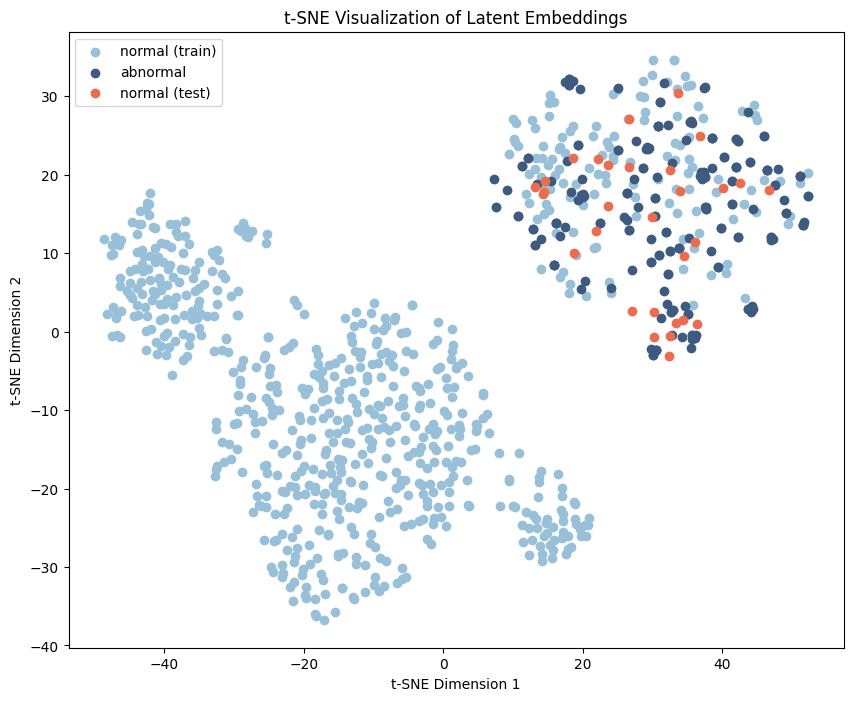

In [95]:
from sklearn.manifold import TSNE
import numpy as np
embeddings_list = list(evaluator.label_latent_dict.values())
embeddings = np.concatenate(embeddings_list, axis=0).squeeze()
categories = np.concatenate([[i]*len(emb) for i, emb in enumerate(embeddings_list)], axis=0).squeeze()
categories_list = list(evaluator.label_latent_dict.keys())

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)


print(embeddings_2d.shape, embeddings.shape, categories.shape)

plt.figure(figsize=(10, 8))
# unique_categories = np.unique(categories)
# for i in range(len(unique_categories)):
#     category = unique_categories[i]
#     indices = np.where(categories == category)
    
#     print(np.where(categories == category))
#     # label = "normal" if categories_list[category] == "normal" else "anomaly"
#     plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=categories_list[category])
indices = np.where(categories == categories_list.index("train"))
plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label="normal (train)", c="#98c1d9")


normal_index = categories_list.index("normal")
indices = np.where(categories == normal_index)
plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label="normal (test)", c="#3d5a80")


indices = np.where(~np.isin(categories, [normal_index, categories_list.index("train")]))
plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label="abnormal", c="#ee6c4d")





plt.title('t-SNE Visualization of Latent Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [68]:
dl = train_data_module.train_dataloader()
for b in dl:
    print(b[0].shape)
    print(b[0].min(),b[0].max())
    break

torch.Size([1, 128, 128])
metatensor(-1.) metatensor(1.)


## Stats

In [69]:
# evaluator.normalize_scores()
evaluator.print_stats_table()

                    Statistics of Anomaly Scores per categroy                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pathology           ┃ Minimum ┃ Maximum ┃ Median ┃ Mean ┃ Variance ┃ #Samples ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ absent_septum       │    0.26 │    0.26 │   0.26 │ 0.26 │     0.00 │        1 │
│ artefacts           │    0.07 │    0.56 │   0.39 │ 0.34 │     0.03 │       16 │
│ craniatomy          │    0.07 │    0.63 │   0.34 │ 0.36 │     0.03 │       15 │
│ dural               │    0.16 │    0.65 │   0.51 │ 0.44 │     0.02 │        7 │
│ ea_mass             │    0.21 │    0.51 │   0.51 │ 0.43 │     0.02 │        4 │
│ edema               │    0.13 │    0.82 │   0.34 │ 0.37 │     0.04 │       18 │
│ encephalomalacia    │    0.54 │    0.54 │   0.54 │ 0.54 │     0.00 │        1 │
│ enlarged_ventricles │    0.07 │    0.72 │   0.40 │ 0.41 │     0.04 │       19 │
│ intraventricular    │    0.46 │    0.46 │   0.46 │ 0.46 │     0.00 │        1 │
│ lesions             │    0.01 │    0.82 │   0.26 │ 0.28 │     0.04 │       22 │
│ mass                │    0.10 │    0.82 │   0.42 │ 0.39 │     0.03 │       22 │
│ posttreatment       │    0.05 │    0.65 │   0.34 │ 0.36 │     0.02 │       44 │
│ resection           │    0.17 │    0.63 │   0.52 │ 0.46 │     0.02 │       10 │
│ sinus               │    0.12 │    0.15 │   0.14 │ 0.14 │     0.00 │        2 │
│ wml                 │    0.25 │    0.39 │   0.33 │ 0.34 │     0.00 │        5 │
│ other               │    0.12 │    0.54 │   0.26 │ 0.31 │     0.03 │        5 │
│ normal              │    0.00 │    1.00 │   0.27 │ 0.32 │     0.05 │       30 │
└─────────────────────┴─────────┴─────────┴────────┴──────┴──────────┴──────────┘

In [70]:
# train_evaluator.print_stats_table()

## Histograms

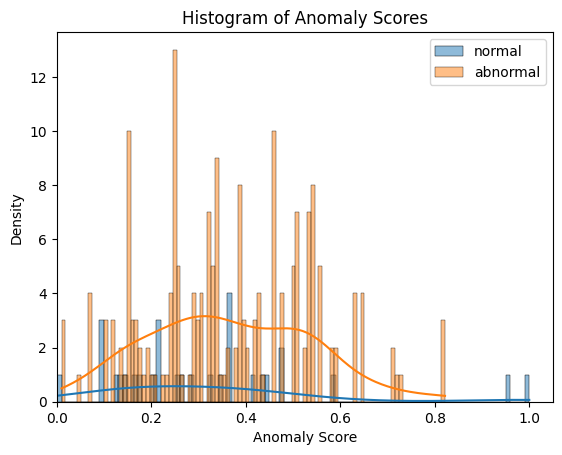

In [71]:
evaluator.histplot()

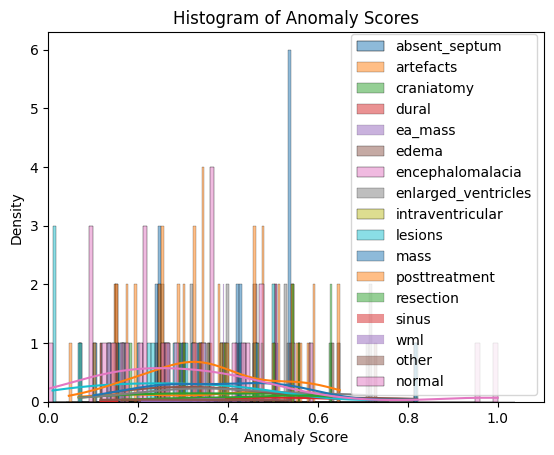

In [72]:
evaluator.histplot(eval_type=EvalType.ALL)

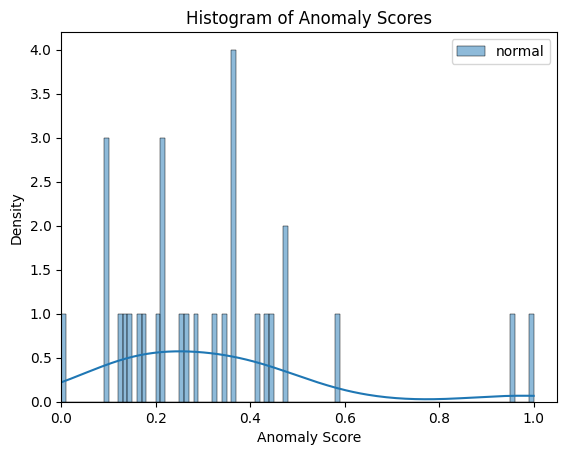

In [73]:
evaluator.histplot(EvalType.NORMAL)

tra

In [74]:
# train_evaluator.histplot(EvalType.TRAIN)

# Metrics

## Find optimal threshold

In [75]:
# optimal_threshold = evaluator.find_optimal_threshold_f1()
# print(optimal_threshold)
# if optimal_threshold == 0:
#     optimal_threshold = 0.03
optimal_threshold = 0.1

## General classification report

In [76]:
evaluator.classification_report(threshold=optimal_threshold)

              precision    recall  f1-score   support

           0       0.33      0.13      0.19        30
           1       0.88      0.96      0.92       192

    accuracy                           0.85       222
   macro avg       0.60      0.55      0.55       222
weighted avg       0.80      0.85      0.82       222



## Confusion matrix

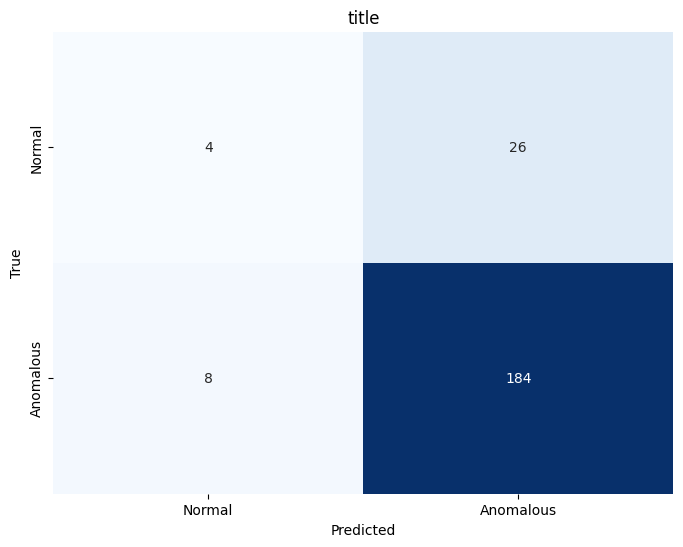

In [77]:
evaluator.plot_confusion_matrix(threshold=optimal_threshold)

## AUROC

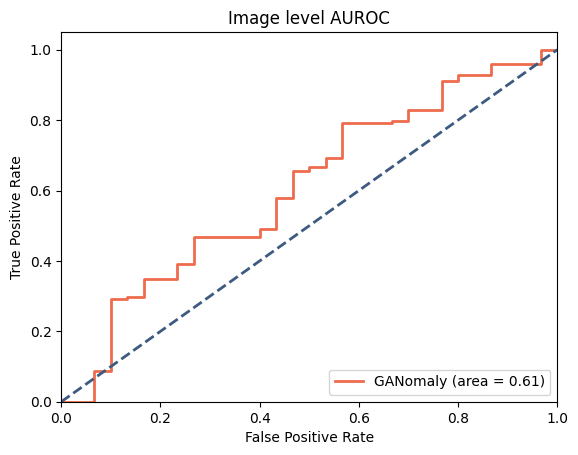

In [78]:
# evaluator.roc_auc_score()
evaluator.plot_auroc(save_fig=True)


## PRC AUC

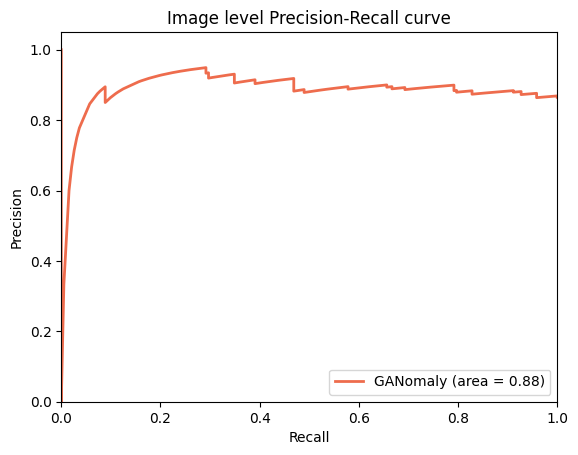

In [79]:
# evaluator.prc_auc_score()
evaluator.plot_auprc(save_fig=True)

# Reconstructions

## Test set - Normal data

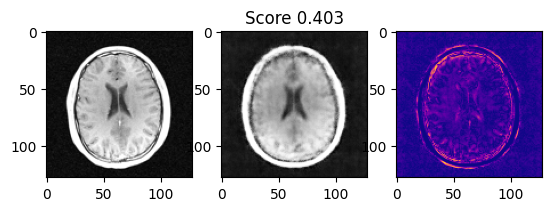

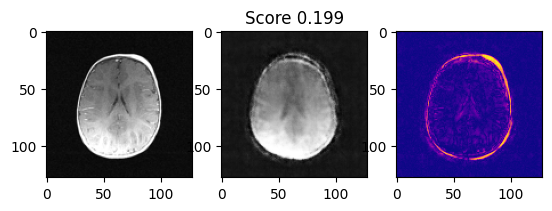

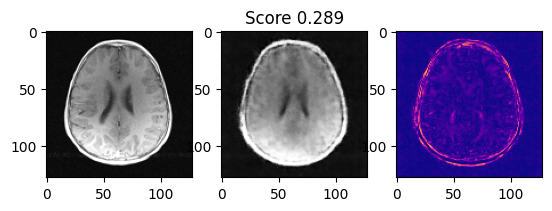

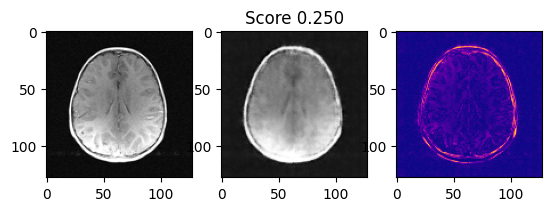

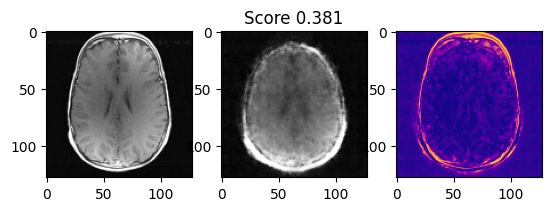

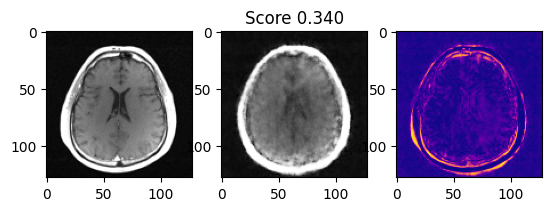

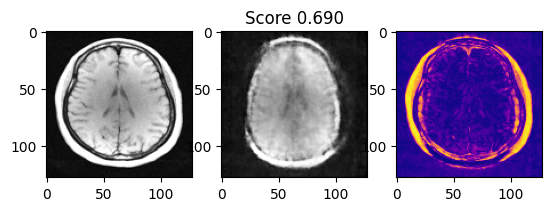

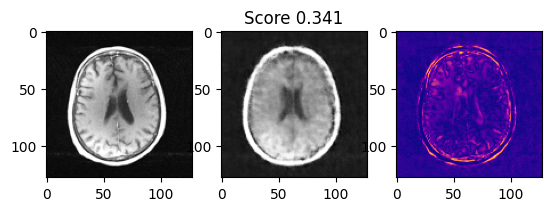

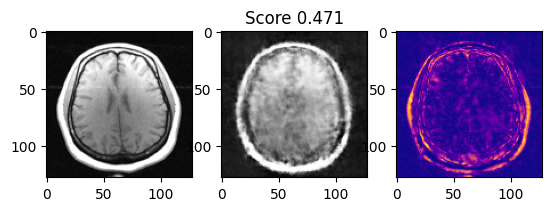

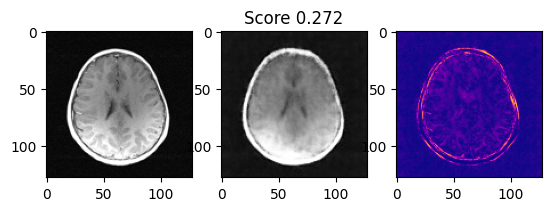

In [80]:
evaluator.plot_in_rec(label="normal", n=10)

## Recon for normal train data

In [81]:
# input_reconstructions_tuples = train_evaluator.label_in_rec_dict["train"]
# N = 8
# fig, ax = plt.subplots(N, 3, figsize=(3,N))
# for i in range(N):
#     input_img, reconstruction_img = input_reconstructions_tuples[i]
#     ax[i][0].imshow(input_img.transpose(1, 2, 0), cmap="gray")
#     # ax[i][0].set_title("Input")
#     ax[i][1].imshow(reconstruction_img.transpose(1, 2, 0), cmap="gray")
#     # ax[i][1].set_title("Reconstruction")
#     diff = input_img - reconstruction_img
#     ax[i][2].imshow(diff.transpose(1, 2, 0), cmap="viridis_r")
#     # ax[i][2].set_title("Difference")
# for ax in ax.flatten():
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.tight_layout()
# plt.show()

In [82]:
# train_evaluator.plot_in_rec(label="train", n=32)


## Recon for abnormal

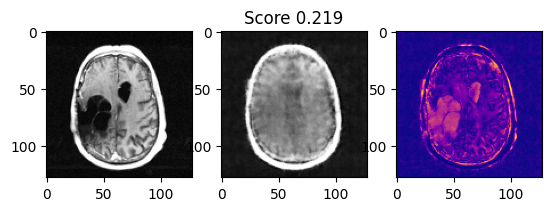

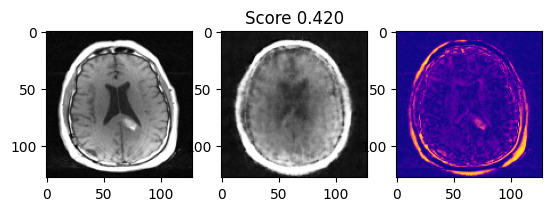

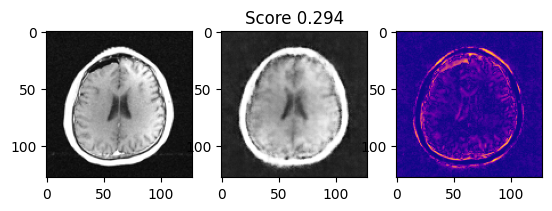

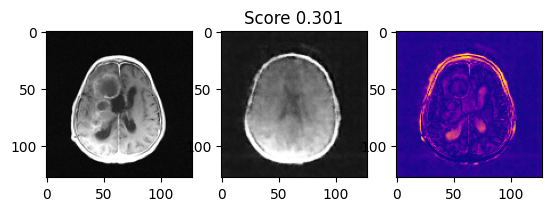

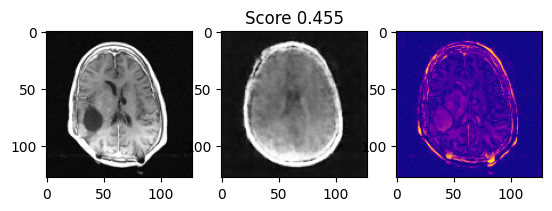

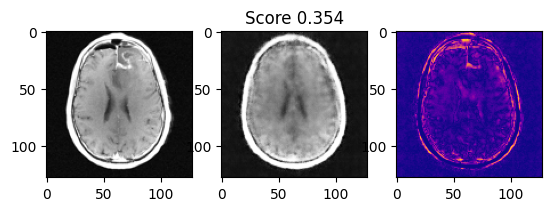

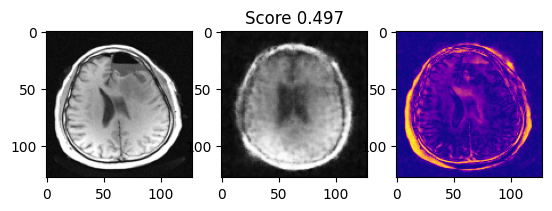

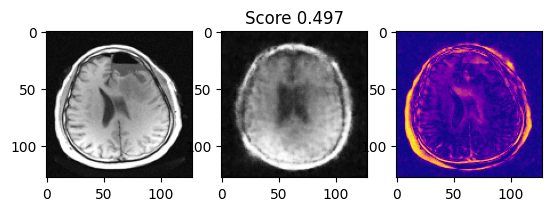

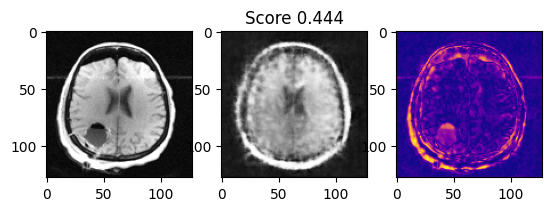

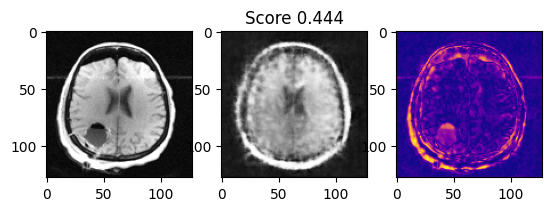

In [83]:
evaluator.plot_in_rec(label="resection", n=10)

In [84]:
# fig_example.savefig(f"example_{config['num_epochs']}.png")